In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from IPython.display import display, HTML, clear_output
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = 'tobacco_grading'
base_dirs = [
    f'{PROJECT_ROOT}/data/raw',
    f'{PROJECT_ROOT}/data/processed/images',
    f'{PROJECT_ROOT}/model',
    f'{PROJECT_ROOT}/output'
]

for path in base_dirs:
    os.makedirs(path, exist_ok=True)

In [3]:
def show_status(message, status_type='info'):
    colors = {
        'info': 'blue',
        'success': 'green',
        'warning': 'orange',
        'error': 'red'
    }
    display(HTML(
        f'<div style="padding:10px; border-left:5px solid {colors[status_type]}; margin:10px">'
        f'<strong>{status_type.upper()}:</strong> {message}'
        '</div>'
    ))

In [4]:
def process_images():
    
    clear_output(wait=True)
    
    progress = FloatProgress(min=0, max=4, description='Processing:')
    display(progress)
    
    try:
        progress.value += 1
        image_paths = []
        for root, _, files in os.walk(f'{PROJECT_ROOT}/data/raw'):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(root, file))
        
        if not image_paths:
            show_status('No images found in raw data directory', 'error')
            return

        metadata = pd.DataFrame({
            'original_path': image_paths,
            'label': [os.path.basename(os.path.dirname(p)) for p in image_paths]
        })
        
        progress.value += 1
        processed_paths = []
        for path in image_paths:
            try:
                img = cv2.imread(path)
                if img is None:
                    continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (64, 64))
                img = cv2.bilateralFilter(img, 9, 75, 75)
                
                rel_path = os.path.relpath(path, start=f'{PROJECT_ROOT}/data/raw')
                dest_path = os.path.join(f'{PROJECT_ROOT}/data/processed/images', rel_path)
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                cv2.imwrite(dest_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
                processed_paths.append(dest_path)
            except Exception as e:
                continue
                
        progress.value += 1
        metadata['processed_path'] = pd.Series(processed_paths)
        metadata.dropna(subset=['processed_path'], inplace=True)
        
        metadata_path = f'{PROJECT_ROOT}/data/processed/metadata.csv'
        metadata.to_csv(metadata_path, index=False)
        
        progress.value += 1
        clear_output()
        show_status(f'Processed {len(metadata)} images successfully', 'success')
        
        display(HTML("<h3>Sample Data:</h3>"))
        display(metadata.sample(3))
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        sample = metadata.iloc[0]
        axes[0].imshow(cv2.imread(sample['original_path'])[..., ::-1])
        axes[0].set_title('Original Image')
        axes[1].imshow(cv2.imread(sample['processed_path'])[..., ::-1])
        axes[1].set_title('Processed Image')
        plt.show()
        
    except Exception as e:
        show_status(f'Processing failed: {str(e)}', 'error')

,original_path,label,processed_path
1502,tobacco_grading/data/raw\L4L_1\kaliua_1824.jpg,L4L_1,tobacco_grading/data/processed/images\L4L_1\ka...
617,tobacco_grading/data/raw\L1O_1\kaliua_127.jpg,L1O_1,tobacco_grading/data/processed/images\L1O_1\ka...
313,tobacco_grading/data/raw\L1L_1\kaliua_5513.jpg,L1L_1,tobacco_grading/data/processed/images\L1L_1\ka...


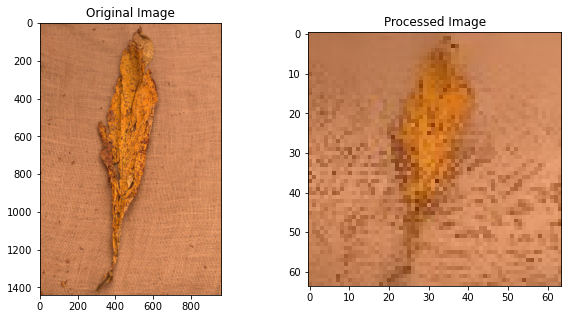

In [5]:
process_images()

In [6]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display, clear_output

In [7]:
def create_feature_extractor():
    """Custom CNN architecture with 4 convolutional blocks"""
    model = Sequential([
        # Block 1
        Conv2D(16, (5,5), input_shape=(64,64,3)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2,2)),
        
        # Block 2
        Conv2D(32, (5,5)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2,2)),
        
        # Block 3
        Conv2D(64, (3,3)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2,2)),
        
        # Block 4
        Conv2D(168, (3,3)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D((2,2)),
    ])
    return model

In [8]:
def load_and_preprocess(image_path):
    try:
        img = load_img(image_path, target_size=(64, 64))
        x = img_to_array(img)
        return x / 255.0 
    except Exception as e:
        print(f"Skipping {os.path.basename(image_path)}: {str(e)}")
        return None

In [9]:
def batch_extract(model, image_paths, batch_size=32):
    features = []
    valid_paths = []
    total_batches = len(image_paths) // batch_size + 1
    
    for batch_idx in range(0, len(image_paths), batch_size):
        clear_output(wait=True)
        print(f"Processing batch {batch_idx//batch_size + 1}/{total_batches}")
        
        batch_paths = image_paths[batch_idx:batch_idx + batch_size]
        batch_images = [load_and_preprocess(p) for p in batch_paths]
        batch_images = [img for img in batch_images if img is not None]
        
        if batch_images:
            batch_array = np.array(batch_images)
            batch_features = model.predict(batch_array, verbose=0)
            features.append(batch_features.reshape((len(batch_images), -1)))
            valid_paths.extend(batch_paths)
    
    return np.vstack(features) if features else np.array([]), valid_paths

In [10]:
PROJECT_ROOT = 'tobacco_grading'
model = create_feature_extractor()
scaler = MinMaxScaler()

In [11]:
metadata_path = f'{PROJECT_ROOT}/data/processed/metadata.csv'
df = pd.read_csv(metadata_path)
df = df[df['processed_path'].notna() & df['processed_path'].apply(os.path.exists)]

In [12]:
features, valid_paths = batch_extract(model, df['processed_path'].tolist())

Processing batch 88/88


In [13]:
if features.size > 0:
    features_scaled = scaler.fit_transform(features)
    feature_cols = [f'feature_{i}' for i in range(features.shape[1])]
    
    final_df = df[df['processed_path'].isin(valid_paths)].copy()
    final_df[feature_cols] = features_scaled
    
    # Save outputs
    final_df.to_csv(f'{PROJECT_ROOT}/data/processed/full_dataset.csv', index=False)
    joblib.dump(scaler, f'{PROJECT_ROOT}/model/feature_scaler.pkl')
    
    print(f"Extracted {features.shape[1]} features from {len(final_df)} images")
    display(final_df[['label'] + feature_cols[:5]].head())
else:
    print("No features extracted - check input images")

Extracted 168 features from 2809 images


,label,feature_0,feature_1,feature_2,feature_3,feature_4
0,L1L_1,0.0,0.0,0.210596,0.0,0.0
1,L1L_1,0.0,0.0,0.020355,0.0,0.0
2,L1L_1,0.0,0.0,0.100039,0.0,0.0
3,L1L_1,0.0,0.0,0.172682,0.0,0.0
4,L1L_1,0.0,0.0,0.098938,0.0,0.0


In [14]:
import pandas as pd
import numpy as np
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [15]:
import os
import pandas as pd
from IPython.display import display, Markdown

PROJECT_ROOT = "tobacco_grading"
dataset_path = f"{PROJECT_ROOT}/data/processed/full_dataset.csv"

In [16]:
try:
    df = pd.read_csv(dataset_path)
    display(Markdown("**Data Preview:**"))
    display(df.head(3))

    X = df.filter(regex="feature_").values
    y = df["label"].values
    display(Markdown(f"✔️ Loaded {X.shape[0]} samples with {X.shape[1]} features"))

except FileNotFoundError:
    display(Markdown(f"<span style='color:red'>❌ Error: {dataset_path} not found!</span>"))

**Data Preview:**

,original_path,label,processed_path,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167
0,tobacco_grading/data/raw\L1L_1\kaliua_1.jpg,L1L_1,tobacco_grading/data/processed/images\L1L_1\ka...,0.0,0.0,0.210596,0.0,0.0,0.308857,0.0,...,0.0,0.0,0.240129,0.378726,0.386687,0.0,0.0,0.0,0.187827,0.389726
1,tobacco_grading/data/raw\L1L_1\kaliua_10.jpg,L1L_1,tobacco_grading/data/processed/images\L1L_1\ka...,0.0,0.0,0.020355,0.0,0.0,0.045748,0.0,...,0.0,0.0,0.462588,0.294527,0.631544,0.0,0.0,0.0,0.336900,0.325288
2,tobacco_grading/data/raw\L1L_1\kaliua_11.jpg,L1L_1,tobacco_grading/data/processed/images\L1L_1\ka...,0.0,0.0,0.100039,0.0,0.0,0.248932,0.0,...,0.0,0.0,0.216002,0.414983,0.514374,0.0,0.0,0.0,0.212290,0.360296


✔️ Loaded 2809 samples with 168 features

### Class Distributions

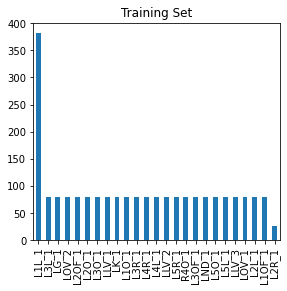

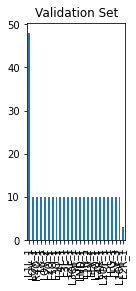

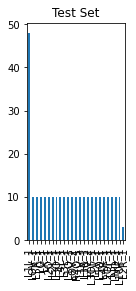

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Visualize class distribution
def plot_class_distribution(y, title):
    pd.Series(y).value_counts().plot(kind='bar', title=title)
    plt.show()

display(Markdown("### Class Distributions"))
plt.figure(figsize=(15,4))
plt.subplot(131)
plot_class_distribution(y_train, "Training Set")
plt.subplot(132)
plot_class_distribution(y_val, "Validation Set")
plt.subplot(133)
plot_class_distribution(y_test, "Test Set")

In [18]:
knn = KNeighborsClassifier(
    n_neighbors=9,
    weights='distance',
    metric='cosine',
    n_jobs=-1
)

display(Markdown("### Training KNN Classifier..."))
knn.fit(X_train, y_train)
display(Markdown("✔️ Training Complete"))

### Training KNN Classifier...

✔️ Training Complete

In [19]:
def evaluate_report(name, X, y):
    y_pred = knn.predict(X)
    report = classification_report(y, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    
    display(Markdown(f"#### {name} Set Performance"))
    display(df_report.style.background_gradient(cmap='Blues', axis=0))

display(Markdown("# Evaluation Results"))
evaluate_report("Training", X_train, y_train)
evaluate_report("Validation", X_val, y_val)
evaluate_report("Test", X_test, y_test)

# Evaluation Results

#### Training Set Performance

,precision,recall,f1-score,support
L1L_1,1.000000,1.000000,1.000000,382.000000
L1OF_1,1.000000,1.000000,1.000000,80.000000
L1O_1,1.000000,1.000000,1.000000,80.000000
L2L_1,1.000000,1.000000,1.000000,80.000000
L2OF_1,1.000000,1.000000,1.000000,80.000000
L2O_1,1.000000,1.000000,1.000000,80.000000
L2R_1,1.000000,1.000000,1.000000,25.000000
L3L_1,1.000000,1.000000,1.000000,80.000000
L3OF_1,1.000000,1.000000,1.000000,80.000000
L3O_1,1.000000,1.000000,1.000000,80.000000


#### Validation Set Performance

,precision,recall,f1-score,support
L1L_1,0.481481,0.812500,0.604651,48.000000
L1OF_1,0.090909,0.100000,0.095238,10.000000
L1O_1,0.571429,0.400000,0.470588,10.000000
L2L_1,0.166667,0.100000,0.125000,10.000000
L2OF_1,0.411765,0.700000,0.518519,10.000000
L2O_1,0.625000,0.500000,0.555556,10.000000
L2R_1,1.000000,0.333333,0.500000,3.000000
L3L_1,0.666667,0.200000,0.307692,10.000000
L3OF_1,0.250000,0.300000,0.272727,10.000000
L3O_1,0.400000,0.200000,0.266667,10.000000


#### Test Set Performance

,precision,recall,f1-score,support
L1L_1,0.542857,0.791667,0.644068,48.000000
L1OF_1,0.555556,0.500000,0.526316,10.000000
L1O_1,0.625000,0.500000,0.555556,10.000000
L2L_1,0.666667,0.400000,0.500000,10.000000
L2OF_1,0.363636,0.400000,0.380952,10.000000
L2O_1,0.250000,0.400000,0.307692,10.000000
L2R_1,0.333333,0.333333,0.333333,3.000000
L3L_1,0.428571,0.300000,0.352941,10.000000
L3OF_1,0.428571,0.600000,0.500000,10.000000
L3O_1,0.500000,0.500000,0.500000,10.000000


In [20]:
try:
    os.makedirs('model', exist_ok=True)
    joblib.dump(knn, 'model/knn_model.pkl')
    display(Markdown("✔️ Model saved to `model/knn_model.pkl`"))
    
except Exception as e:
    display(Markdown(f"<span style='color:red'>❌ Save failed: {str(e)}</span>"))

✔️ Model saved to `model/knn_model.pkl`

In [21]:
display(Markdown("### Final Checks"))
display(Markdown(f"- Model Type: {type(knn)}"))
display(Markdown(f"- Feature Dimensions: {X_train.shape[1]}"))
display(Markdown(f"- Classes: {np.unique(y)}"))

### Final Checks

- Model Type: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>

- Feature Dimensions: 168

- Classes: ['L1L_1' 'L1OF_1' 'L1O_1' 'L2L_1' 'L2OF_1' 'L2O_1' 'L2R_1' 'L3L_1'
 'L3OF_1' 'L3O_1' 'L3R_1' 'L4L_1' 'L4R_1' 'L5L_1' 'L5O_1' 'L5R_1' 'LG_1'
 'LK_1' 'LLV_1' 'LLV_2' 'LLV_3' 'LND_1' 'LOV_1' 'LOV_2' 'R4O_1']